In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors
import numpy as np
import glob
mpl.style.use('seaborn-talk')
import ROOT

Welcome to JupyROOT 6.16/00


In [2]:
%%cpp -d

#include "sPhenixStyle.C"
#include "SaveCanvas.C"
#include <TStyle.h>

In [3]:
%%cpp

SetsPhenixStyle();
gStyle->SetOptStat(0);
gStyle->SetOptFit(1111);
TVirtualFitter::SetDefaultFitter("Minuit2");

gSystem->Load("libg4eval.so");

sPhenixStyle: Applying nominal settings.
sPhenixStyle: ROOT6 mode


In [4]:
# base_dir = 'production-3-full-beam-full-magnet'
# # base_dir = 'production-3-tail-full-magnet'

# detector_map = {
#     'MAPS Vertex' : ['MVTX'],
#     'TPC Tracker' : ['SVTX'],
#     'e-going GEM' : ['EGEM_0', 'EGEM_1', 'EGEM_2', 'EGEM_3'],
#     'h-going GEM' : ['FGEM_2', 'FGEM_3', 'FGEM_4'],
#     'Forward Silicon' : ['FST_0', 'FST_1','FST_2','FST_3','FST_4'],
    
#     'Central Pipe' : ['PIPE'],
# }


# base_dir = 'production-4-full-beam-full-magnet'
# base_dir = 'production-4-tail-full-magnet'


# base_dir = 'production-5-full-beam-full-magnet'
# base_dir = 'production-5-tail-full-magnet'

# base_dir = 'production-6-CharlieGeometry'
# base_dir = 'production-6-UpdatedGeometryPumps'

# base_dir = 'production-7-2um-CharlieGeometry'
# base_dir = 'production-7-2um-CharlieGeometry'

# base_dir = 'production-8-24JulyFirstRun'
base_dir = 'production-8-Au2um-24JulyFirstRun'

# force_rebuild_sum = False;
force_rebuild_sum = True;

detector_map = {
    'MAPS Vertex' : ['MVTX'],
    'TPC Tracker' : ['TPC'],
    'e-going GEM' : ['EGEM_0', 'EGEM_1', 'EGEM_2', 'EGEM_3'],
    'h-going GEM' : ['FGEM_2', 'FGEM_3', 'FGEM_4'],
    'Forward Silicon' : ['FST_0', 'FST_1','FST_2','FST_3','FST_4'],
    'Central Pipe' : ['PIPE'],
}

CautiousLabel = f'Internal preview only\ntag {base_dir}'

In [5]:
df_facets= pd.read_csv(os.path.join(base_dir, 'Facet_CheckAll.csv'))
df_facets.set_index('Facet', inplace=True)
df_facets

,Flux,Phi
Facet,,
14868.0,2.540000e+15,0.086656
14869.0,2.540000e+15,-0.086503
14870.0,2.290000e+15,-0.259229
14871.0,1.830000e+15,-0.433566
14872.0,1.440000e+15,-0.607762
14886.0,1.210000e+16,-3.061573
14887.0,1.210000e+16,3.061904
14888.0,5.430000e+15,2.892673
14889.0,2.500000e+15,2.714309


In [6]:
# facet = int(18966)

for facet_f in df_facets.index.to_list():
    facet = int(facet_f)
    filenames = glob.glob(os.path.join(base_dir, f'{facet}.[0-9]*.csv_SynRadAna.root'))
#     print(len(filenames))

    src_filenames=" ".join(filenames);
    joint_file = os.path.join(base_dir, f'{facet}_SUM.csv_SynRadAna.root')

    if ((not os.path.exists(joint_file)) or force_rebuild_sum):
        print(os.popen(f'hadd -f {joint_file} {src_filenames} ').read())
    else:
        print(os.popen(f'ls -lhv {joint_file} ').read())

hadd Target file: production-8-Au2um-24JulyFirstRun/14868_SUM.csv_SynRadAna.root
hadd compression setting for all ouput: 1
hadd Source file 1: production-8-Au2um-24JulyFirstRun/14868.0034.csv_SynRadAna.root
hadd Source file 2: production-8-Au2um-24JulyFirstRun/14868.0046.csv_SynRadAna.root
hadd Source file 3: production-8-Au2um-24JulyFirstRun/14868.0098.csv_SynRadAna.root
hadd Source file 4: production-8-Au2um-24JulyFirstRun/14868.0279.csv_SynRadAna.root
hadd Source file 5: production-8-Au2um-24JulyFirstRun/14868.0163.csv_SynRadAna.root
hadd Source file 6: production-8-Au2um-24JulyFirstRun/14868.0089.csv_SynRadAna.root
hadd Source file 7: production-8-Au2um-24JulyFirstRun/14868.0086.csv_SynRadAna.root
hadd Source file 8: production-8-Au2um-24JulyFirstRun/14868.0233.csv_SynRadAna.root
hadd Source file 9: production-8-Au2um-24JulyFirstRun/14868.0212.csv_SynRadAna.root
hadd Source file 10: production-8-Au2um-24JulyFirstRun/14868.0106.csv_SynRadAna.root
hadd Source file 11: production-8-Au

In [7]:
dict_rate = {'Facet' : [], 'Flux' : [],'Phi' : [],'Flux_Normalization_Scale' : []}


print(detector_map)

for name, entries in detector_map.items():
    dict_rate[name] = []
    for entry in entries:
        dict_rate[entry] = []

print(dict_rate)


for facet_f in df_facets.index.to_list():
    facet = int(facet_f)
    
#     if (facet == 18965 or facet == 18987 ):
#         continue;
    
    joint_file = os.path.join(base_dir, f'{facet}_SUM.csv_SynRadAna.root')
    facet_flux_noarmlized = df_facets.loc[facet,'Flux']
    facet_phi_ave = df_facets.loc[facet,'Phi']
    
    root_file = ROOT.TFile.Open(joint_file)
    h_SynRadAna_Normalization = root_file.Get('h_SynRadAna_Normalization')
    facet_flux_noarmlization_scale = facet_flux_noarmlized / h_SynRadAna_Normalization.GetBinContent(3);
    print(f'Facet {facet} scale = {facet_flux_noarmlization_scale:.2e} @ phi = {facet_phi_ave:.2f}')
    
    dict_rate['Facet'].append(facet)
    dict_rate['Flux'].append(facet_flux_noarmlized)
    dict_rate['Phi'].append(facet_phi_ave)
    dict_rate['Flux_Normalization_Scale'].append(facet_flux_noarmlization_scale)
    
    for detector_group, entries in detector_map.items():
        group_rate = 0
        
        for detector in entries:
            
            h_SynRadAna_nHit = root_file.Get(f'h_SynRadAna_{detector}_nHit')
            h_SynRadAna_nHit = root_file.Get(f'h_SynRadAna_{detector}_nHit')
            h_SynRadAna_nHit_flux = h_SynRadAna_nHit.ProjectionX(f'h_SynRadAna_{detector}_nHit_flux',1,1)
            h_SynRadAna_nHit_flux.Scale(facet_flux_noarmlization_scale);
            # Rate sum hit
#             Rate = h_SynRadAna_nHit_flux.GetMean()*h_SynRadAna_nHit_flux.GetSum()
            #rate sum photons
            Rate = h_SynRadAna_nHit_flux.Integral(2,-1)
        
            group_rate = group_rate + Rate

            dict_rate[detector].append(Rate)
            
        dict_rate[detector_group].append(group_rate)

{'MAPS Vertex': ['MVTX'], 'TPC Tracker': ['TPC'], 'e-going GEM': ['EGEM_0', 'EGEM_1', 'EGEM_2', 'EGEM_3'], 'h-going GEM': ['FGEM_2', 'FGEM_3', 'FGEM_4'], 'Forward Silicon': ['FST_0', 'FST_1', 'FST_2', 'FST_3', 'FST_4'], 'Central Pipe': ['PIPE']}
{'Facet': [], 'Flux': [], 'Phi': [], 'Flux_Normalization_Scale': [], 'MAPS Vertex': [], 'MVTX': [], 'TPC Tracker': [], 'TPC': [], 'e-going GEM': [], 'EGEM_0': [], 'EGEM_1': [], 'EGEM_2': [], 'EGEM_3': [], 'h-going GEM': [], 'FGEM_2': [], 'FGEM_3': [], 'FGEM_4': [], 'Forward Silicon': [], 'FST_0': [], 'FST_1': [], 'FST_2': [], 'FST_3': [], 'FST_4': [], 'Central Pipe': [], 'PIPE': []}
Facet 14868 scale = 2.80e-06 @ phi = 0.09
Facet 14869 scale = 2.80e-06 @ phi = -0.09
Facet 14870 scale = 2.49e-06 @ phi = -0.26
Facet 14871 scale = 1.99e-06 @ phi = -0.43
Facet 14872 scale = 1.57e-06 @ phi = -0.61
Facet 14886 scale = 1.30e-05 @ phi = -3.06
Facet 14887 scale = 1.30e-05 @ phi = 3.06
Facet 14888 scale = 5.98e-06 @ phi = 2.89
Facet 14889 scale = 2.74e-0

In [8]:
df_rate = pd.DataFrame(dict_rate)
df_rate.set_index('Phi', inplace=True)

df_rate

,Facet,Flux,Flux_Normalization_Scale,MAPS Vertex,MVTX,TPC Tracker,TPC,e-going GEM,EGEM_0,EGEM_1,...,FGEM_3,FGEM_4,Forward Silicon,FST_0,FST_1,FST_2,FST_3,FST_4,Central Pipe,PIPE
Phi,,,,,,,,,,,,,,,,,,,,,
0.086656,14868,2.540000e+15,2.803021e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,3.284929e+14,3.284929e+14
-0.086503,14869,2.540000e+15,2.799258e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,3.286371e+14,3.286371e+14
-0.259229,14870,2.290000e+15,2.493208e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,3.023126e+14,3.023126e+14
-0.433566,14871,1.830000e+15,1.993646e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,2.435929e+14,2.435929e+14
-0.607762,14872,1.440000e+15,1.572773e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,1.942630e+14,1.942630e+14
-3.061573,14886,1.210000e+16,1.300384e-05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,4.033655e+14,4.033655e+14
3.061904,14887,1.210000e+16,1.301418e-05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,4.132489e+14,4.132489e+14
2.892673,14888,5.430000e+15,5.976849e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,3.840907e+14,3.840907e+14
2.714309,14889,2.500000e+15,2.737496e-06,1.357527e+08,1.357527e+08,0.000000e+00,0.000000e+00,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,3.004237e+14,3.004237e+14


In [9]:
h_SynRadAna_Normalization

<ROOT.TH1D object ("h_SynRadAna_Normalization") at 0x86b9900>

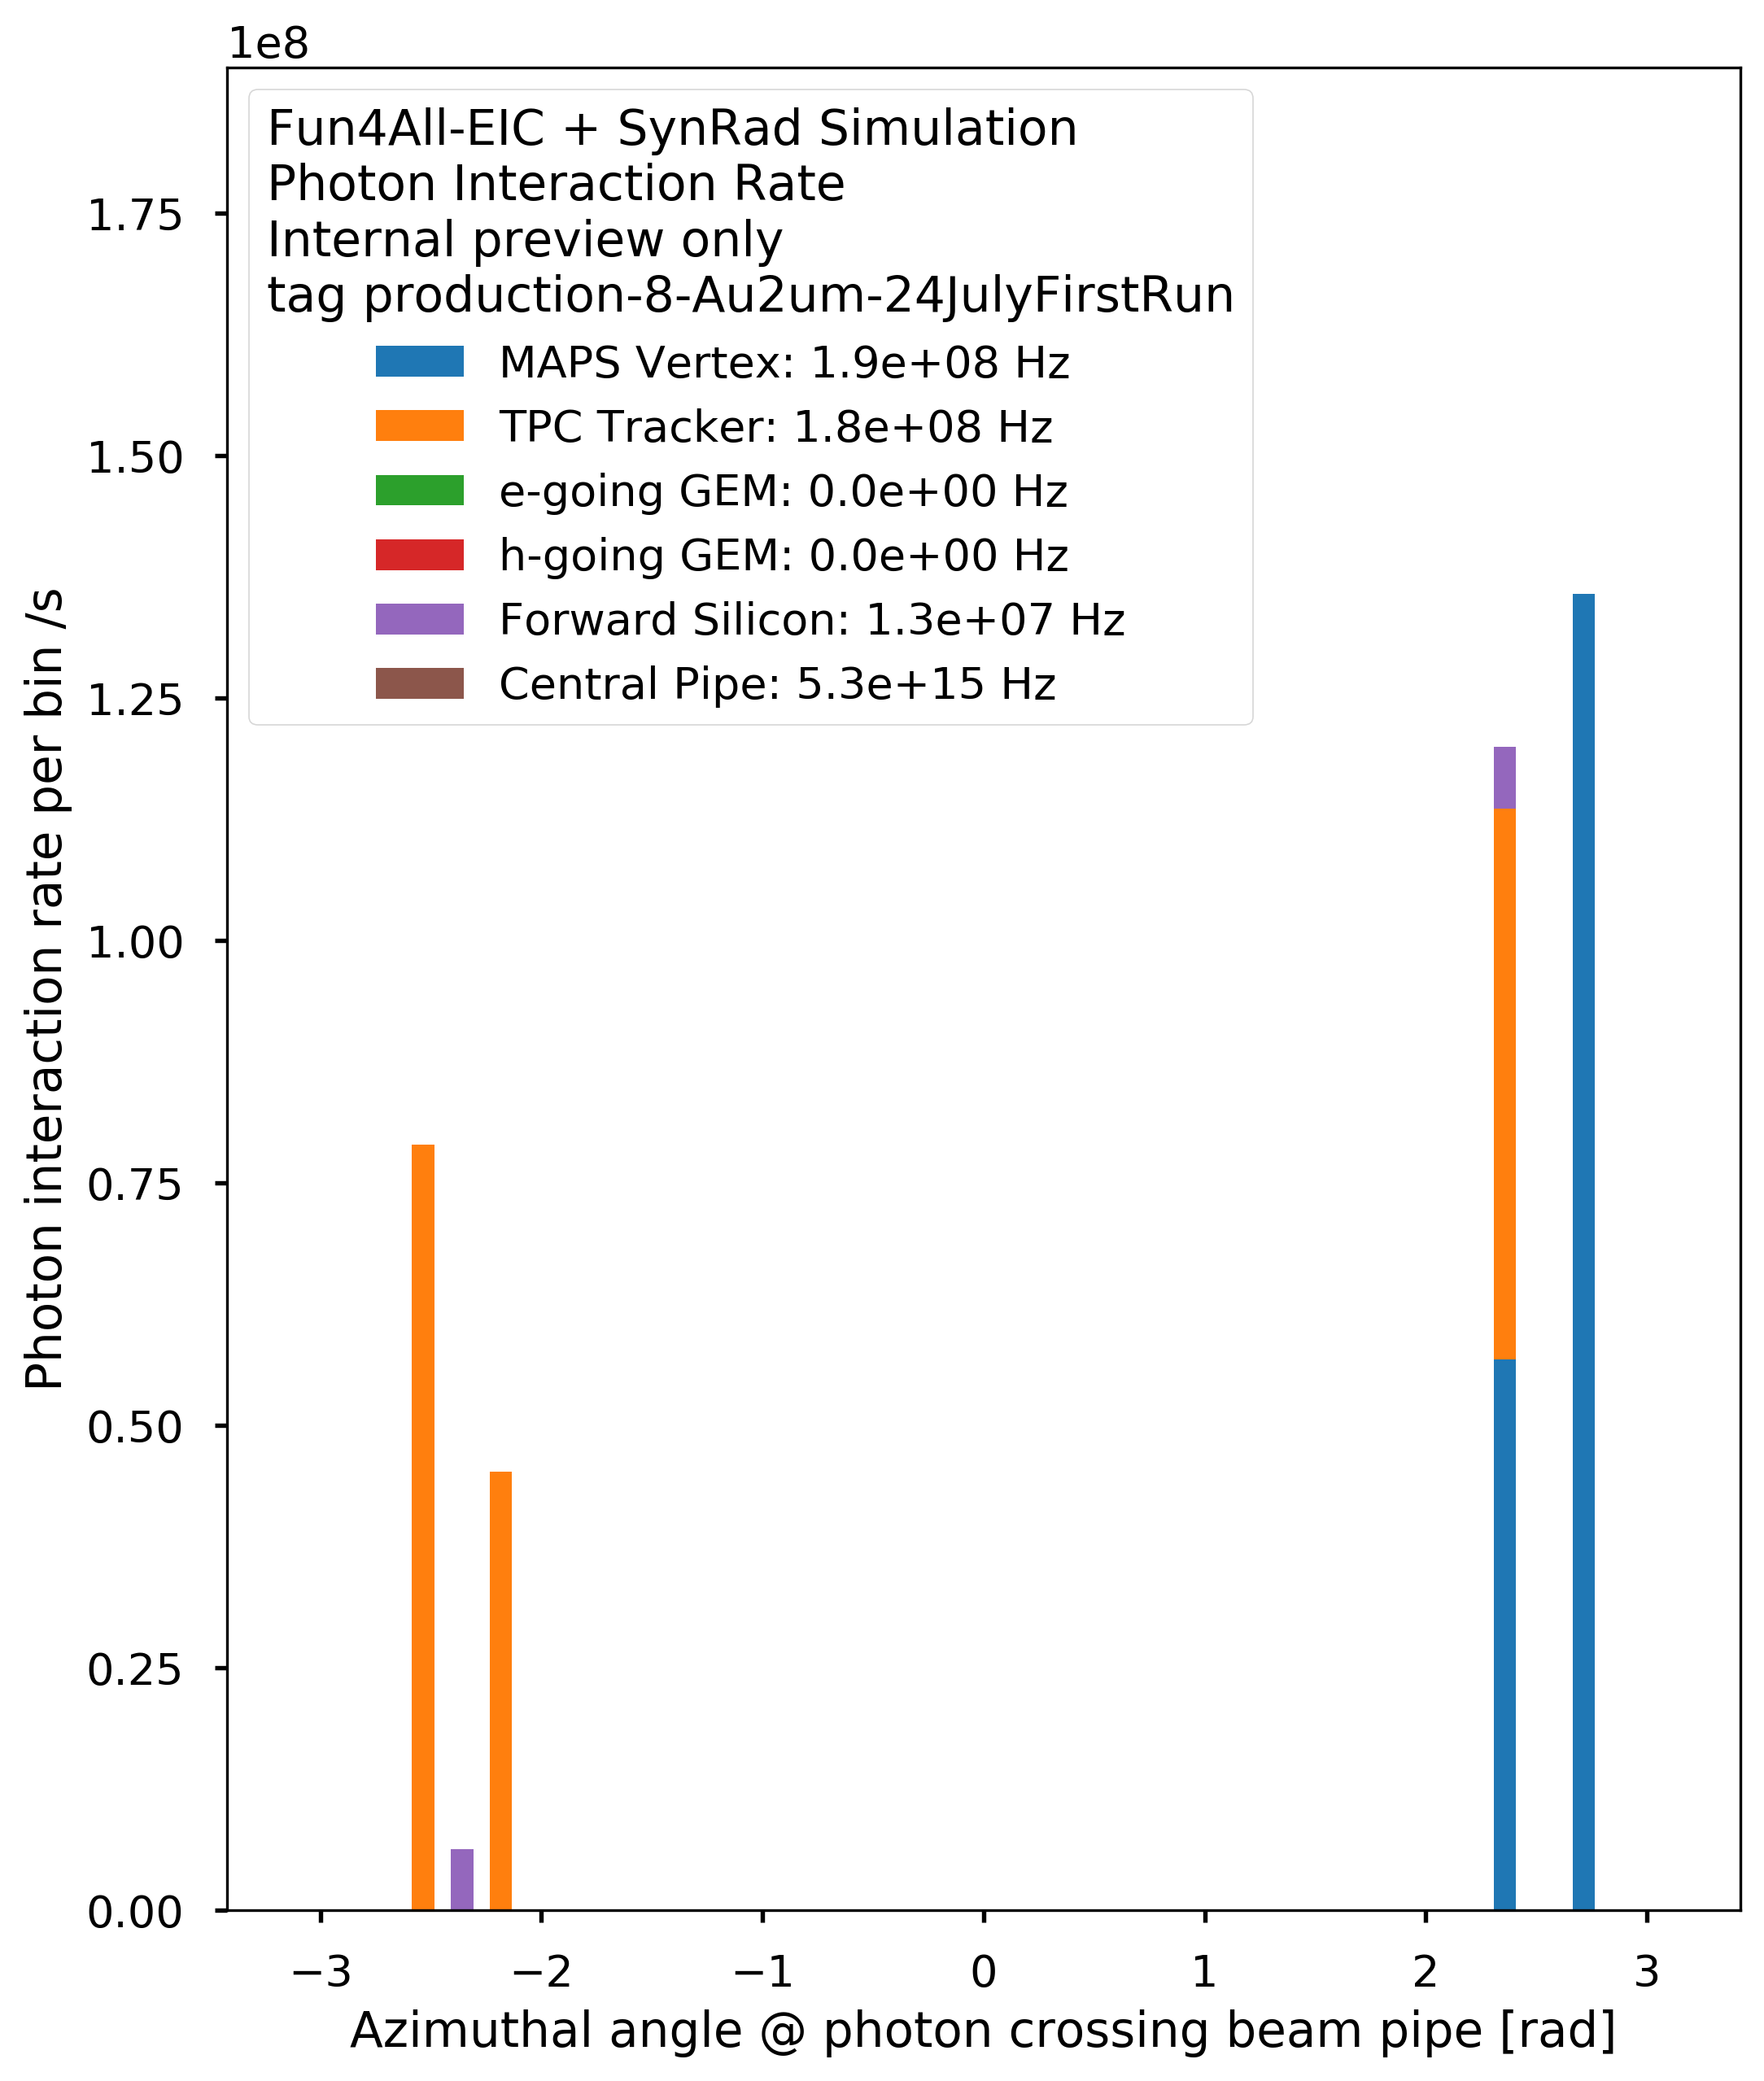

In [10]:
width = 0.1

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 10), dpi=300)
ax=axs


baserate = np.zeros(df_rate['Facet'].count())

for detector_group, entries in detector_map.items():
    rates = df_rate[detector_group].to_numpy()
    sum_rate = np.sum(rates)
    
    # not to plot the beam pipe rate which go through the roof...
    if (detector_group == 'Central Pipe'): 
        rates = np.zeros(df_rate['Facet'].count())
           
    ax.bar(
        df_rate.index.to_numpy(), 
        rates,  width , 
        bottom= baserate,
        label = f'{detector_group}: {sum_rate:.1e} Hz');
    
    baserate = rates + baserate;
    
ax.set_ylim((0, 1.4*ax.get_ylim()[1]))
ax.set_xlabel("Azimuthal angle @ photon crossing beam pipe [rad]");
ax.set_ylabel("Photon interaction rate per bin /s");
ax.legend(loc='upper left',
         title = f'Fun4All-EIC + SynRad Simulation\nPhoton Interaction Rate\n{CautiousLabel}',
         title_fontsize='x-large'
         )
# chartBox = ax.get_position()
# ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.8, chartBox.height])
# ax.legend(loc='upper center', bbox_to_anchor=(1.45, 1), ncol=1,
#          title = f'Fun4All-EIC + SynRad Simulation\n{CautiousLabel}',
#          title_fontsize='x-large'
#          )


plt.savefig(os.path.join(base_dir, 'Photon Interaction Rate.png'), bbox_inches='tight')
plt.savefig(os.path.join(base_dir, 'Photon Interaction Rate.pdf'), bbox_inches='tight')

In [11]:
# Layer hit rate

first_facet = True;

MVTX_rate = np.zeros(100)
TPC_rate = np.zeros(100)

for facet_f in df_facets.index.to_list():
    facet = int(facet_f)
    
    joint_file = os.path.join(base_dir, f'{facet}_SUM.csv_SynRadAna.root')
    facet_flux_noarmlized = df_facets.loc[facet,'Flux']
    facet_phi_ave = df_facets.loc[facet,'Phi']
    
    root_file = ROOT.TFile.Open(joint_file)
    h_SynRadAna_Normalization = root_file.Get('h_SynRadAna_Normalization')
    facet_flux_noarmlization_scale = facet_flux_noarmlized / h_SynRadAna_Normalization.GetBinContent(3);
    print(f'Facet {facet} scale = {facet_flux_noarmlization_scale:.2e} @ phi = {facet_phi_ave:.2f}')
    
    
    h_SynRadAna_MVTXHit_nHit_Layer =  root_file.Get('h_SynRadAna_MVTXHit_nHit_Layer')
    h_SynRadAna_TPCHit_nHit_Layer =  root_file.Get('h_SynRadAna_TPCHit_nHit_Layer')
#     h_SynRadAna_MVTXHit_nHit_Layer_scaled = h_SynRadAna_MVTXHit_nHit_Layer;
#     h_SynRadAna_MVTXHit_nHit_Layer_scaled.Scale(facet_flux_noarmlization_scale);
    for bin_nhit in range(1, h_SynRadAna_MVTXHit_nHit_Layer.GetNbinsX()+1):
        nhit = h_SynRadAna_MVTXHit_nHit_Layer.GetXaxis().GetBinCenter(bin_nhit);
        if nhit<0.5:
            continue;
            
        for bin_layer in range(1, h_SynRadAna_MVTXHit_nHit_Layer.GetNbinsY()+1):
            layer = h_SynRadAna_MVTXHit_nHit_Layer.GetYaxis().GetBinCenter(bin_layer);
            MVTX_rate[int(layer)] = MVTX_rate[int(layer)] + nhit* h_SynRadAna_MVTXHit_nHit_Layer.GetBinContent(bin_nhit, bin_layer) * facet_flux_noarmlization_scale;

    for bin_nhit in range(1, h_SynRadAna_TPCHit_nHit_Layer.GetNbinsX()+1):
        nhit = h_SynRadAna_TPCHit_nHit_Layer.GetXaxis().GetBinCenter(bin_nhit);
        if nhit<0.5:
            continue;
            
        for bin_layer in range(1, h_SynRadAna_TPCHit_nHit_Layer.GetNbinsY()+1):
            layer = h_SynRadAna_TPCHit_nHit_Layer.GetYaxis().GetBinCenter(bin_layer);
            TPC_rate[int(layer)] = TPC_rate[int(layer)] + nhit* h_SynRadAna_TPCHit_nHit_Layer.GetBinContent(bin_nhit, bin_layer) * facet_flux_noarmlization_scale;

            
            
            
    

    

Facet 14868 scale = 2.80e-06 @ phi = 0.09
Facet 14869 scale = 2.80e-06 @ phi = -0.09
Facet 14870 scale = 2.49e-06 @ phi = -0.26
Facet 14871 scale = 1.99e-06 @ phi = -0.43
Facet 14872 scale = 1.57e-06 @ phi = -0.61
Facet 14886 scale = 1.30e-05 @ phi = -3.06
Facet 14887 scale = 1.30e-05 @ phi = 3.06
Facet 14888 scale = 5.98e-06 @ phi = 2.89
Facet 14889 scale = 2.74e-06 @ phi = 2.71
Facet 14890 scale = 1.60e-06 @ phi = 2.54
Facet 14891 scale = 1.15e-06 @ phi = 2.36
Facet 14892 scale = 9.17e-07 @ phi = 2.18
Facet 14893 scale = 8.00e-07 @ phi = 2.01
Facet 14901 scale = 1.56e-06 @ phi = 0.61
Facet 14902 scale = 2.00e-06 @ phi = 0.43
Facet 14903 scale = 2.51e-06 @ phi = 0.26
Facet 14881 scale = 9.12e-07 @ phi = -2.18
Facet 14882 scale = 1.15e-06 @ phi = -2.36
Facet 14883 scale = 1.59e-06 @ phi = -2.54
Facet 14884 scale = 2.74e-06 @ phi = -2.71
Facet 14885 scale = 5.96e-06 @ phi = -2.89


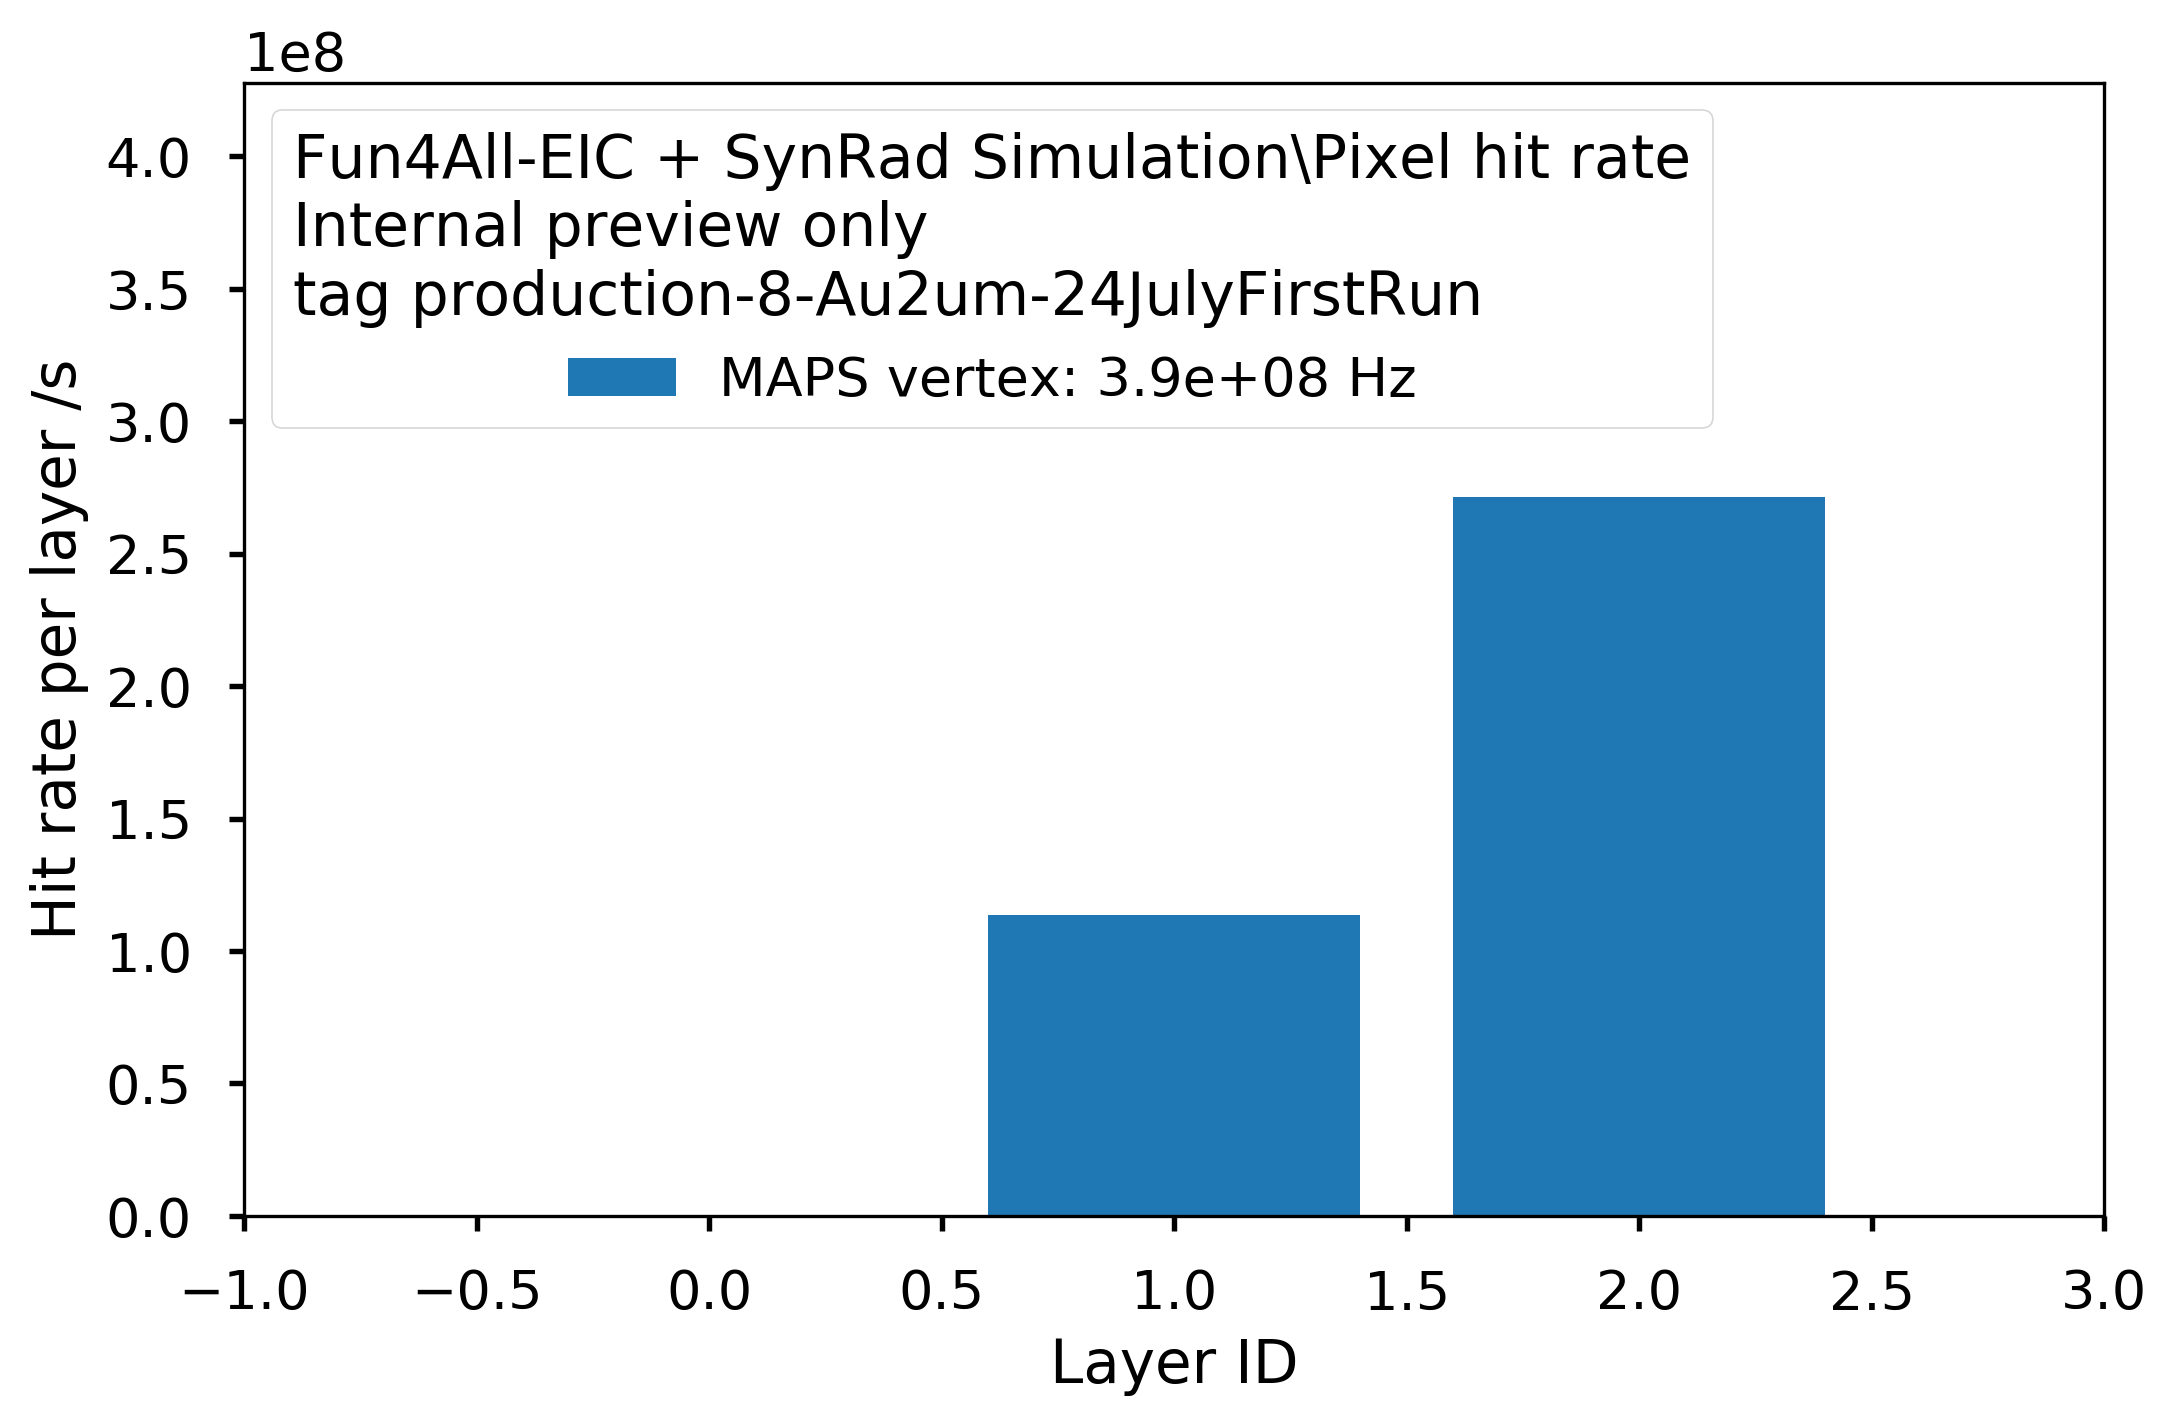

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), dpi=300)
ax=axs

sum_rate = np.sum(MVTX_rate);

ax.bar(
    range(100), 
    MVTX_rate, 
    label = f'MAPS vertex: {sum_rate:.1e} Hz');

ax.set_xlim((-1, 3))
ax.set_ylim((0, 1.5*ax.get_ylim()[1]))
# ax.set_yscale('symlog');
ax.set_xlabel("Layer ID");
ax.set_ylabel("Hit rate per layer /s");
ax.legend(loc='upper left',
         title = f'Fun4All-EIC + SynRad Simulation\Pixel hit rate\n{CautiousLabel}',
         title_fontsize='x-large'
         )
# chartBox = ax.get_position()
# ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.8, chartBox.height])
# ax.legend(loc='upper center', bbox_to_anchor=(1.45, 1), ncol=1,
#          title = f'Fun4All-EIC + SynRad Simulation\n{CautiousLabel}',
#          title_fontsize='x-large'
#          )


plt.savefig(os.path.join(base_dir, 'MVTX Hit Rate.png'), bbox_inches='tight')
plt.savefig(os.path.join(base_dir, 'MVTX Hit Rate.pdf'), bbox_inches='tight')

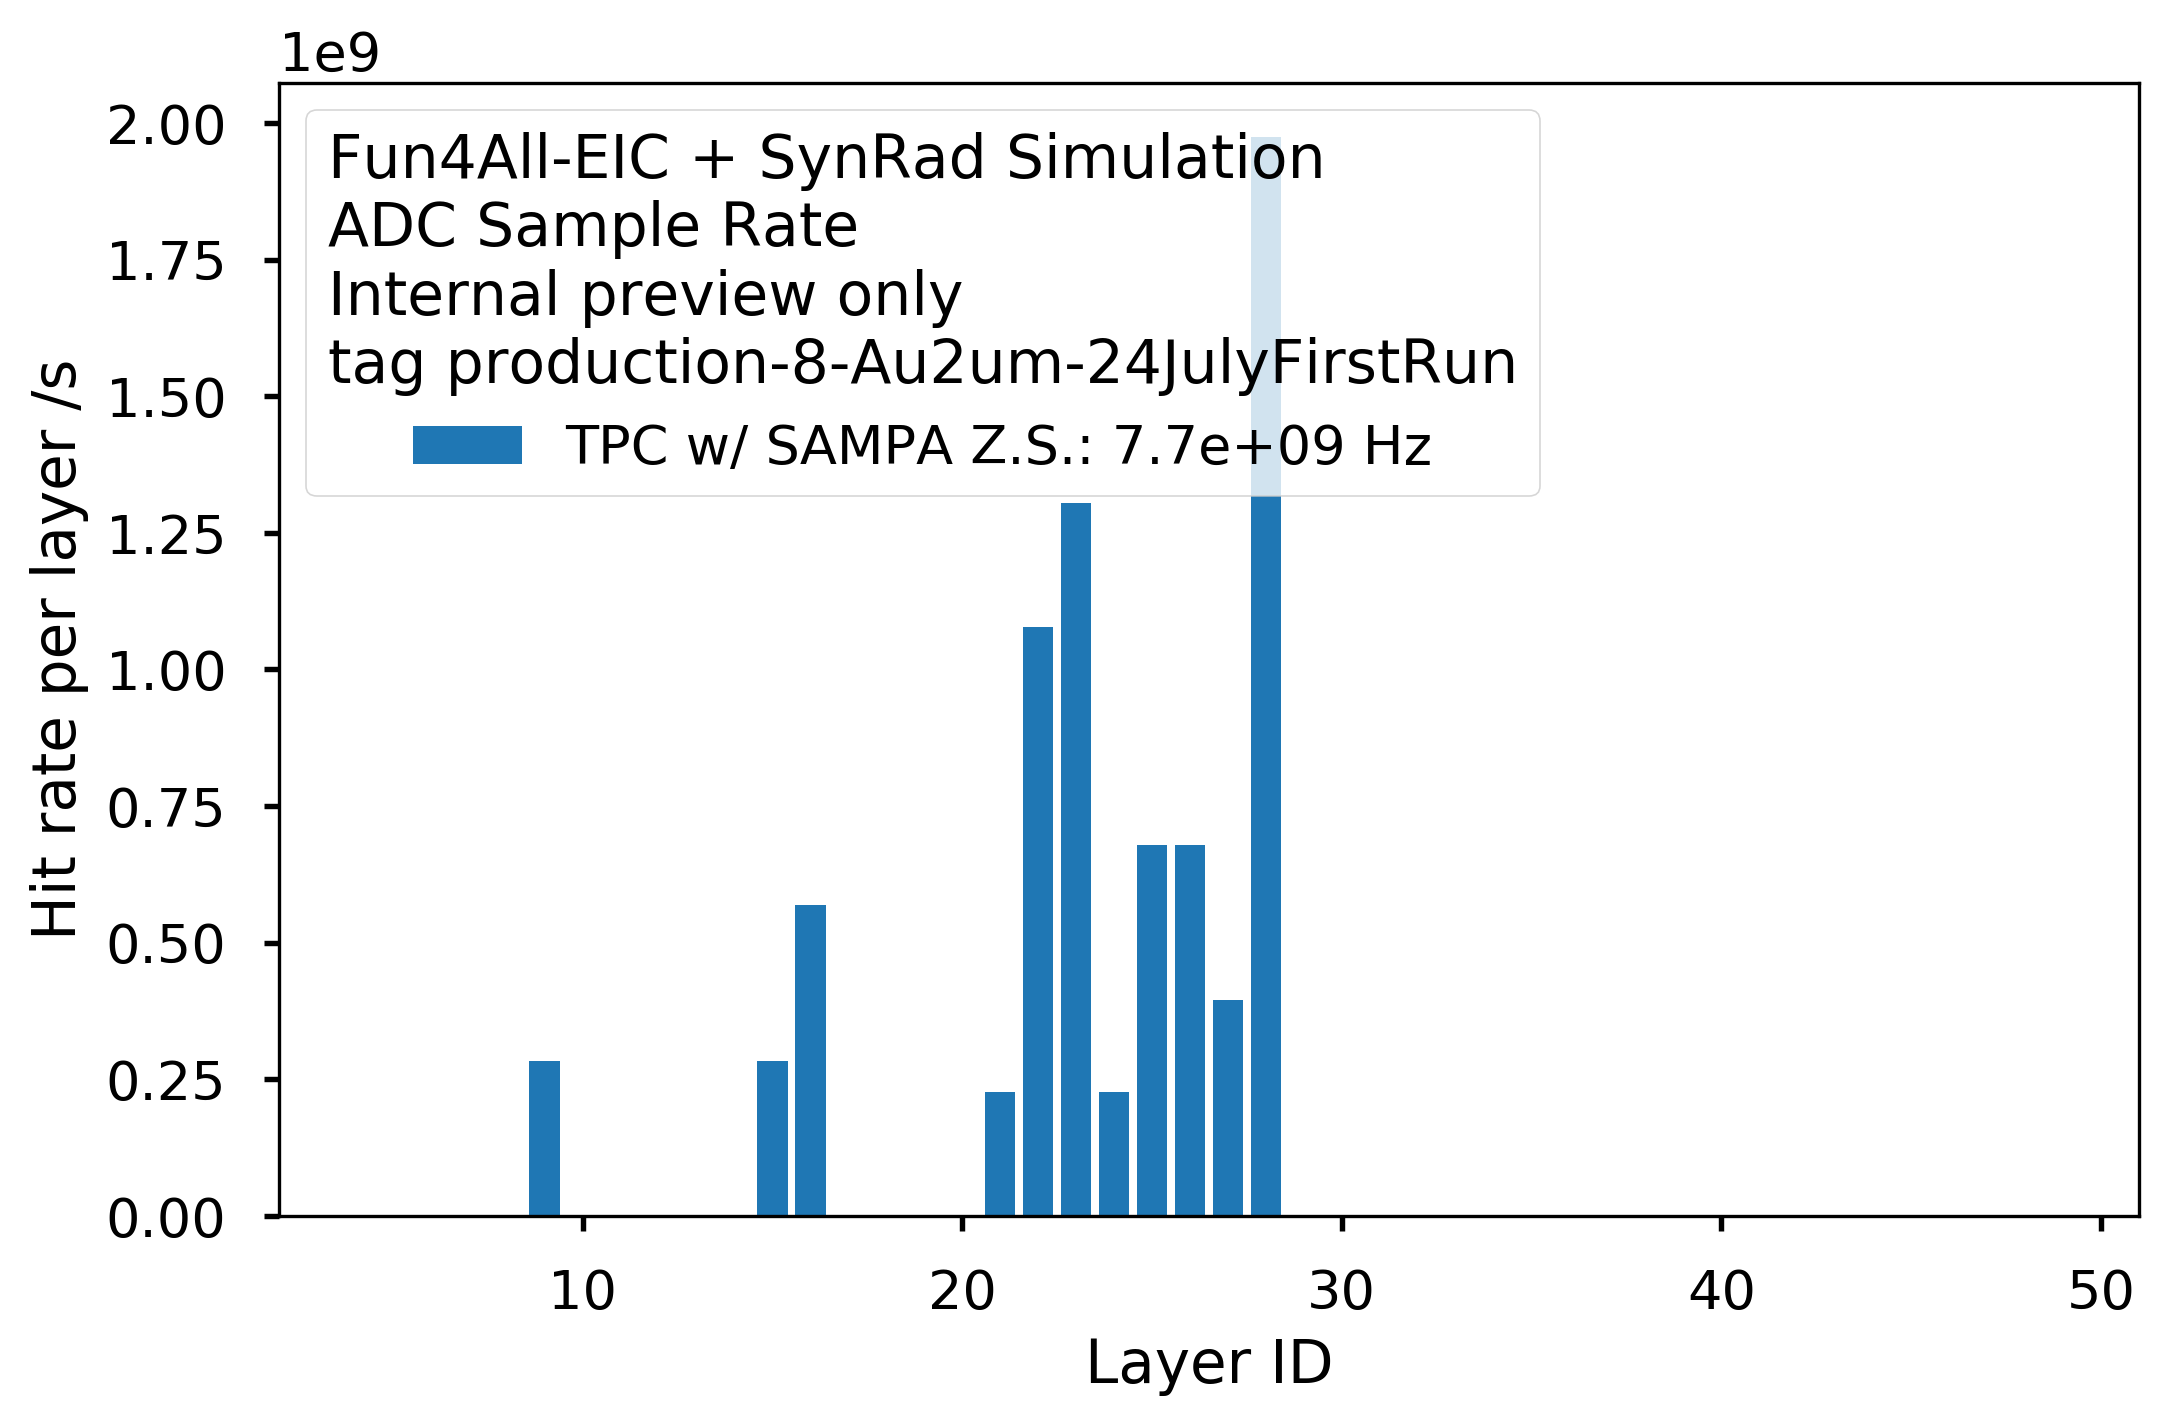

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), dpi=300)
ax=axs

sum_rate = np.sum(TPC_rate);

ax.bar(
    range(100), 
    TPC_rate, 
    label = f'TPC w/ SAMPA Z.S.: {sum_rate:.1e} Hz');

ax.set_xlim((2, 51))
ax.set_ylim((0, 1.*ax.get_ylim()[1]))
# ax.set_yscale('symlog');
ax.set_xlabel("Layer ID");
ax.set_ylabel("Hit rate per layer /s");
ax.legend(loc='upper left',
         title = f'Fun4All-EIC + SynRad Simulation\nADC Sample Rate\n{CautiousLabel}',
         title_fontsize='x-large'
         )
# chartBox = ax.get_position()
# ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.8, chartBox.height])
# ax.legend(loc='upper center', bbox_to_anchor=(1.45, 1), ncol=1,
#          title = f'Fun4All-EIC + SynRad Simulation\n{CautiousLabel}',
#          title_fontsize='x-large'
#          )


plt.savefig(os.path.join(base_dir, 'TPC Hit Rate.png'), bbox_inches='tight')
plt.savefig(os.path.join(base_dir, 'TPC Hit Rate.pdf'), bbox_inches='tight')

In [14]:
facet = 18966

joint_file = os.path.join(base_dir, f'{facet}_SUM.csv_SynRadAna.root')
facet_flux_noarmlized = df_facets.loc[facet,'Flux']
facet_phi_ave = df_facets.loc[facet,'Phi']

root_file = ROOT.TFile.Open(joint_file)
h_SynRadAna_Normalization = root_file.Get('h_SynRadAna_Normalization')
facet_flux_noarmlization_scale = facet_flux_noarmlized / h_SynRadAna_Normalization.GetBinContent(3);
print(f'Facet {facet} scale = {facet_flux_noarmlization_scale:.2e} @ phi = {facet_phi_ave:.2f}')

KeyError: 18966.0

In [ ]:
detector_group = 'MAPS Vertex'
detector = 'MVTX'
h_SynRadAna_nHit = root_file.Get(f'h_SynRadAna_{detector}_nHit')
h_SynRadAna_nHit_flux = h_SynRadAna_nHit.ProjectionX(f'h_SynRadAna_{detector}_nHit_flux',1,1)
h_SynRadAna_nHit_flux.Scale(facet_flux_noarmlization_scale);

print( h_SynRadAna_nHit_flux.GetMean()*h_SynRadAna_nHit_flux.GetSum())
print( f'{h_SynRadAna_nHit_flux.Integral(2,-1):.3e}')

In [ ]:
print( f'{h_SynRadAna_nHit_flux.GetBinContent(1):.3e}')

In [ ]:
c1 = ROOT.TCanvas( 'Check', 'Check', 1000, 1000)
c1.Divide(2, 2);
idx = 1;

p = c1.cd(idx);
idx = idx + 1;
c1.Update();
p.SetLogy();

h_SynRadAna_Normalization.Draw();


p = c1.cd(idx);
idx = idx + 1;
c1.Update();
p.SetLogy();

h_SynRadAna_photonEnergy = root_file.Get('h_SynRadAna_photonEnergy')
h_SynRadAna_photonEnergy_flux = h_SynRadAna_photonEnergy.ProjectionX('h_SynRadAna_photonEnergy_flux',1,1)
h_SynRadAna_photonEnergy_flux.Scale(facet_flux_noarmlization_scale);
h_SynRadAna_photonEnergy_flux.Rebin(10)
h_SynRadAna_photonEnergy_flux.GetXaxis().SetRangeUser(-.5,20);
h_SynRadAna_photonEnergy_flux.Draw();


p = c1.cd(idx);
idx = idx + 1;
c1.Update();
p.SetLogy();

h_SynRadAna_MVTXHit_nHit = root_file.Get('h_SynRadAna_MVTXHit_nHit')
h_SynRadAna_MVTXHit_nHit_flux = h_SynRadAna_MVTXHit_nHit.ProjectionX('h_SynRadAna_MVTXHit_nHit_flux',1,1)
h_SynRadAna_MVTXHit_nHit_flux.Scale(facet_flux_noarmlization_scale);
h_SynRadAna_MVTXHit_nHit_flux.GetXaxis().SetRangeUser(-.5,20);
h_SynRadAna_MVTXHit_nHit_flux.Draw();


p = c1.cd(idx);
idx = idx + 1;
c1.Update();
p.SetLogy();

h_SynRadAna_MVTX_nHit = root_file.Get('h_SynRadAna_MVTX_nHit')
h_SynRadAna_MVTX_nHit_flux = h_SynRadAna_MVTX_nHit.ProjectionX('h_SynRadAna_MVTX_nHit_flux',1,1)
h_SynRadAna_MVTX_nHit_flux.Scale(facet_flux_noarmlization_scale);
h_SynRadAna_MVTX_nHit_flux.GetXaxis().SetRangeUser(-.5,20);
h_SynRadAna_MVTX_nHit_flux.Draw();

c1.Draw()


ROOT.SaveCanvas(c1,f'{joint_file}_Check', True);

In [ ]:
c1 = ROOT.TCanvas( 'Check2', 'Check2', 1000, 1000)
# c1.Divide(2, 2);
idx = 1;

p = c1.cd(idx);
idx = idx + 1;
c1.Update();
p.SetLogy();

h_SynRadAna_photonEnergy = root_file.Get('h_SynRadAna_photonEnergy')
h_SynRadAna_photonEnergy_flux = h_SynRadAna_photonEnergy.ProjectionX('h_SynRadAna_photonEnergy_flux',1,1)
h_SynRadAna_photonEnergy_flux.Scale(facet_flux_noarmlization_scale);
h_SynRadAna_photonEnergy_flux.Rebin(10)
h_SynRadAna_photonEnergy_flux.GetXaxis().SetRangeUser(-.5,20);
h_SynRadAna_photonEnergy_flux.Draw();
h_SynRadAna_photonEnergy_flux.GetYaxis().SetRangeUser(1e11,h_SynRadAna_photonEnergy_flux.GetMaximum());


h_SynRadAna_PIPE_photonEnergy = root_file.Get('h_SynRadAna_PIPE_photonEnergy')
h_SynRadAna_PIPE_photonEnergy_flux = h_SynRadAna_PIPE_photonEnergy.ProjectionX('h_SynRadAna_PIPE_photonEnergy_flux',1,1)
h_SynRadAna_PIPE_photonEnergy_flux.Scale(facet_flux_noarmlization_scale);
h_SynRadAna_PIPE_photonEnergy_flux.Rebin(10);
h_SynRadAna_PIPE_photonEnergy_flux.Draw('same');
h_SynRadAna_PIPE_photonEnergy_flux.SetLineColor(ROOT.kBlue+2);
h_SynRadAna_PIPE_photonEnergy_flux.SetMarkerColor(ROOT.kBlue+2);

c1.Draw()
ROOT.SaveCanvas(c1,f'{joint_file}_Check2', True);

In [ ]:
c1 = ROOT.TCanvas( 'MVTXHitLayers', 'MVTXHitLayers', 1000, 1000)
c1.Divide(2, 1);
idx = 1;

p = c1.cd(idx);
idx = idx + 1;
c1.Update();
p.SetLogy();

h_SynRadAna_MVTXHit_nHit_Layer =  root_file.Get('h_SynRadAna_MVTXHit_nHit_Layer')
h_SynRadAna_MVTXHit_nHit_Layer.ProjectionY().Draw('colz');


p = c1.cd(idx);
idx = idx + 1;
c1.Update();
p.SetLogy();

h_SynRadAna_TPCHit_nHit_Layer =  root_file.Get('h_SynRadAna_TPCHit_nHit_Layer')
h_SynRadAna_TPCHit_nHit_Layer.ProjectionY().Draw('colz');

c1.Draw()
ROOT.SaveCanvas(c1,f'{joint_file}_MVTXHitLayers', True);

In [ ]:
root_file.ls()

In [15]:
# from time import sleep
# from IPython.display import display, Javascript
# import hashlib

# def save_notebook(file_path):
#     start_md5 = hashlib.md5(open(file_path,'rb').read()).hexdigest()
#     display(Javascript('IPython.notebook.save_checkpoint();'))
#     current_md5 = start_md5

#     while start_md5 == current_md5:
#         sleep(1)
#         current_md5 = hashlib.md5(open(file_path,'rb').read()).hexdigest()
        
#     print(f'saved to {file_path} {start_md5} -> {current_md5}');


# save_notebook('CheckAll.ipynb')
os.system('jupyter nbconvert --to html RateCalculation.ipynb')
print(os.popen(f'mv -fv RateCalculation.html \'{base_dir}/\'').read())


‘RateCalculation.html’ -> ‘production-8-Au2um-24JulyFirstRun/RateCalculation.html’



[NbConvertApp] Converting notebook RateCalculation.ipynb to html
[NbConvertApp] Writing 1656354 bytes to RateCalculation.html
